In [1]:
import abc
import collections
import enum
import math
import pathlib
import typing
import warnings

import numpy as np
import torch
import torch.optim
import torch.utils.data
import tqdm
from matplotlib import pyplot as plt

from util import draw_reliability_diagram, cost_function, setup_seeds, calc_calibration_curve

In [2]:
EXTENDED_EVALUATION = False
"""
Set `EXTENDED_EVALUATION` to `True` in order to generate additional plots on validation data.
"""

USE_PRETRAINED_INIT = True
"""
If `USE_PRETRAINED_INIT` is `True`, then MAP inference uses provided pretrained weights.
You should not modify MAP training or the CNN architecture before passing the hard baseline.
If you set the constant to `False` (to further experiment),
this solution always performs MAP inference before running your SWAG implementation.
Note that MAP inference can take a long time.
"""

'\nIf `USE_PRETRAINED_INIT` is `True`, then MAP inference uses provided pretrained weights.\nYou should not modify MAP training or the CNN architecture before passing the hard baseline.\nIf you set the constant to `False` (to further experiment),\nthis solution always performs MAP inference before running your SWAG implementation.\nNote that MAP inference can take a long time.\n'

In [3]:
class InferenceMode(enum.Enum):
    """
    Inference mode switch for your implementation.
    `MAP` simply predicts the most likely class using pretrained MAP weights.
    `SWAG_DIAGONAL` and `SWAG_FULL` correspond to SWAG-diagonal and the full SWAG method, respectively.
    """
    MAP = 0
    SWAG_DIAGONAL = 1
    SWAG_FULL = 2

In [39]:
class SWAGInference(object):
    """
    Your implementation of SWA-Gaussian.
    This class is used to run and evaluate your solution.
    You must preserve all methods and signatures of this class.
    However, you can add new methods if you want.

    We provide basic functionality and some helper methods.
    You can pass all baselines by only modifying methods marked with TODO.
    However, we encourage you to skim other methods in order to gain a better understanding of SWAG.
    """

    def __init__(
        self,
        train_xs: torch.Tensor,
        model_dir: pathlib.Path,
        # TODO(1): change inference_mode to InferenceMode.SWAG_DIAGONAL
        # TODO(2): change inference_mode to InferenceMode.SWAG_FULL
        inference_mode: InferenceMode = InferenceMode.SWAG_FULL,
        # TODO(2): optionally add/tweak hyperparameters
        swag_epochs: int = 30,
        swag_learning_rate: float = 0.045,
        swag_update_freq: int = 1,
        deviation_matrix_max_rank: int = 15,
        bma_samples: int = 30,
    ):
        """
        :param train_xs: Training images (for storage only)
        :param model_dir: Path to directory containing pretrained MAP weights
        :param inference_mode: Control which inference mode (MAP, SWAG-diagonal, full SWAG) to use
        :param swag_epochs: Total number of gradient descent epochs for SWAG
        :param swag_learning_rate: Learning rate for SWAG gradient descent
        :param swag_update_freq: Frequency (in epochs) for updating SWAG statistics during gradient descent
        :param deviation_matrix_max_rank: Rank of deviation matrix for full SWAG
        :param bma_samples: Number of networks to sample for Bayesian model averaging during prediction
        """

        self.model_dir = model_dir
        self.inference_mode = inference_mode
        self.swag_epochs = swag_epochs
        self.swag_learning_rate = swag_learning_rate
        self.swag_update_freq = swag_update_freq
        self.deviation_matrix_max_rank = deviation_matrix_max_rank
        self.bma_samples = bma_samples

        # Network used to perform SWAG.
        # Note that all operations in this class modify this network IN-PLACE!
        self.network = CNN(in_channels=3, out_classes=6)

        # Store training dataset to recalculate batch normalization statistics during SWAG inference
        self.train_dataset = torch.utils.data.TensorDataset(train_xs)

        # SWAG-diagonal
        # TODO(1): create attributes for SWAG-diagonal
        #  Hint: self._create_weight_copy() creates an all-zero copy of the weights
        #  as a dictionary that maps from weight name to values.
        #  Hint: you never need to consider the full vector of weights,
        #  but can always act on per-layer weights (in the format that _create_weight_copy() returns)
        self.weights_list = {name: collections.deque() for name, _ in self.network.named_parameters()}
        self.weights_sum = self._create_weight_copy()
        self.weights_squares_sum = self._create_weight_copy()
        self.weights_first_moment = self._create_weight_copy()
        self.weights_second_moment = self._create_weight_copy()
        self.weights_first_moment_alt = self._create_weight_copy()
        self.weights_second_moment_alt = self._create_weight_copy()
        self.weights_num = 0

        # Full SWAG
        # TODO(2): create attributes for SWAG-diagonal
        #  Hint: check collections.deque
        self.weights_deviation = {name: collections.deque(maxlen=self.deviation_matrix_max_rank) for name, _ in self.network.named_parameters()}
        

        # Calibration, prediction, and other attributes
        # TODO(2): create additional attributes, e.g., for calibration
        self._prediction_threshold = None  # this is an example, feel free to be creative

    def update_swag(self) -> None:
        """
        Update SWAG statistics with the current weights of self.network.
        """

        # Create a copy of the current network weights
        current_params = {name: param.detach().clone() for name, param in self.network.named_parameters()}

        for name, param in current_params.items():
            # SWAG-diagonal
            # TODO(1): update SWAG-diagonal attributes for weight `name` using `current_params` and `param`
            # Inspired by Welford's online algorithm https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
            self.weights_list[name].append(param)
            self.weights_sum[name] += param
            self.weights_squares_sum[name] += param**2
            self.weights_first_moment[name] = ( self.weights_num * self.weights_first_moment[name] + param ) / ( self.weights_num + 1 )
            self.weights_second_moment[name] = ( self.weights_num * self.weights_second_moment[name] + param**2 ) / ( self.weights_num + 1 )
            self.weights_first_moment_alt[name] += ( param - self.weights_first_moment_alt[name]) / ( self.weights_num + 1 )
            self.weights_second_moment_alt[name] += ( param**2 - self.weights_second_moment_alt[name]) / ( self.weights_num + 1 )
            
            # Full SWAG
            if self.inference_mode == InferenceMode.SWAG_FULL:
                # TODO(2): update full SWAG attributes for weight `name` using `current_params` and `param`
                self.weights_deviation[name].append(param - self.weights_first_moment[name])
        
        self.weights_num += 1
        



    def fit_swag(self, loader: torch.utils.data.DataLoader) -> None:
        """
        Fit SWAG on top of the pretrained network self.network.
        This method should perform gradient descent with occasional SWAG updates
        by calling self.update_swag().
        """

        # We use SGD with momentum and weight decay to perform SWA.
        # See the paper on how weight decay corresponds to a type of prior.
        # Feel free to play around with optimization hyperparameters.
        optimizer = torch.optim.SGD(
            self.network.parameters(),
            lr=self.swag_learning_rate,
            momentum=0.9,
            nesterov=False,
            weight_decay=1e-4,
        )
        loss = torch.nn.CrossEntropyLoss(
            reduction="mean",
        )
        # TODO(2): Update SWAGScheduler instantiation if you decided to implement a custom schedule.
        #  By default, this scheduler just keeps the initial learning rate given to `optimizer`.
        lr_scheduler = SWAGScheduler(
            optimizer,
            epochs=self.swag_epochs,
            steps_per_epoch=len(loader),
        )

        # TODO(1): Perform initialization for SWAG fitting
        self.weights_list = {name: collections.deque([param.detach().clone()]) for name, param in self.network.named_parameters()}
        self.weights_sum = {name: param.detach().clone() for name, param in self.network.named_parameters()}
        self.weights_squares_sum = {name: param.detach().clone()**2 for name, param in self.network.named_parameters()}
        self.weights_first_moment = {name: param.detach().clone() for name, param in self.network.named_parameters()}
        self.weights_second_moment = {name: param.detach().clone()**2 for name, param in self.network.named_parameters()}
        self.weights_first_moment_alt = {name: param.detach().clone() for name, param in self.network.named_parameters()}
        self.weights_second_moment_alt = {name: param.detach().clone()**2 for name, param in self.network.named_parameters()}
        self.weights_num = 1

        self.network.train()
        with tqdm.trange(self.swag_epochs, desc="Running gradient descent for SWA") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                average_loss = 0.0
                average_accuracy = 0.0
                num_samples_processed = 0
                for batch_xs, batch_is_snow, batch_is_cloud, batch_ys in loader:
                    optimizer.zero_grad()
                    pred_ys = self.network(batch_xs)
                    batch_loss = loss(input=pred_ys, target=batch_ys)
                    batch_loss.backward()
                    optimizer.step()
                    pbar_dict["lr"] = lr_scheduler.get_last_lr()[0]
                    lr_scheduler.step()

                    # Calculate cumulative average training loss and accuracy
                    average_loss = (batch_xs.size(0) * batch_loss.item() + num_samples_processed * average_loss) / (
                        num_samples_processed + batch_xs.size(0)
                    )
                    average_accuracy = (
                        torch.sum(pred_ys.argmax(dim=-1) == batch_ys).item()
                        + num_samples_processed * average_accuracy
                    ) / (num_samples_processed + batch_xs.size(0))
                    num_samples_processed += batch_xs.size(0)
                    pbar_dict["avg. epoch loss"] = average_loss
                    pbar_dict["avg. epoch accuracy"] = average_accuracy
                    pbar.set_postfix(pbar_dict)

                # TODO(1): Implement periodic SWAG updates using the attributes defined in __init__
                if epoch % self.swag_update_freq == 0:
                    self.update_swag()

    def calibrate(self, validation_data: torch.utils.data.Dataset) -> None:
        """
        Calibrate your predictions using a small validation set.
        validation_data contains well-defined and ambiguous samples,
        where you can identify the latter by having label -1.
        """
        if self.inference_mode == InferenceMode.MAP:
            # In MAP mode, simply predict argmax and do nothing else
            self._prediction_threshold = 0.0
            return

        # TODO(1): pick a prediction threshold, either constant or adaptive.
        #  The provided value should suffice to pass the easy baseline.
        self._prediction_threshold = 2.0 / 3.0

        # TODO(2): perform additional calibration if desired.
        #  Feel free to remove or change the prediction threshold.
        val_xs, val_is_snow, val_is_cloud, val_ys = validation_data.tensors
        assert val_xs.size() == (140, 3, 60, 60)  # N x C x H x W
        assert val_ys.size() == (140,)
        assert val_is_snow.size() == (140,)
        assert val_is_cloud.size() == (140,)

    def predict_probabilities_swag(self, loader: torch.utils.data.DataLoader) -> torch.Tensor:
        """
        Perform Bayesian model averaging using your SWAG statistics and predict
        probabilities for all samples in the loader.
        Outputs should be a Nx6 tensor, where N is the number of samples in loader,
        and all rows of the output should sum to 1.
        That is, output row i column j should be your predicted p(y=j | x_i).
        """

        self.network.eval()

        # Perform Bayesian model averaging:
        # Instead of sampling self.bma_samples networks (using self.sample_parameters())
        # for each datapoint, you can save time by sampling self.bma_samples networks,
        # and perform inference with each network on all samples in loader.
        per_model_sample_predictions = []
        for _ in tqdm.trange(self.bma_samples, desc="Performing Bayesian model averaging"):
            # TODO(1): Sample new parameters for self.network from the SWAG approximate posterior
            self.sample_parameters()

            # TODO(1): Perform inference for all samples in `loader` using current model sample,
            #  and add the predictions to per_model_sample_predictions
            predictions = self.predict_probabilities_map(loader)
            per_model_sample_predictions.append(predictions)

        assert len(per_model_sample_predictions) == self.bma_samples
        assert all(
            isinstance(model_sample_predictions, torch.Tensor)
            and model_sample_predictions.dim() == 2  # N x C
            and model_sample_predictions.size(1) == 6
            for model_sample_predictions in per_model_sample_predictions
        )

        # TODO(1): Average predictions from different model samples into bma_probabilities
        bma_probabilities = torch.stack(per_model_sample_predictions).mean(dim=0)

        assert bma_probabilities.dim() == 2 and bma_probabilities.size(1) == 6  # N x C
        return bma_probabilities

    def sample_parameters(self) -> None:
        """
        Sample a new network from the approximate SWAG posterior.
        For simplicity, this method directly modifies self.network in-place.
        Hence, after calling this method, self.network corresponds to a new posterior sample.
        """

        # Instead of acting on a full vector of parameters, all operations can be done on per-layer parameters.
        for name, param in self.network.named_parameters():
            # SWAG-diagonal part
            z_1 = torch.randn(param.size())
            # TODO(1): Sample parameter values for SWAG-diagonal
            current_mean = self.weights_first_moment[name]
            current_std = torch.sqrt(torch.abs(self.weights_second_moment[name] - self.weights_first_moment[name]**2))
            
            assert current_mean.size() == param.size() and current_std.size() == param.size()

            # Diagonal part
            sampled_param = current_mean + current_std * z_1

            # Full SWAG part
            if self.inference_mode == InferenceMode.SWAG_FULL:
                # TODO(2): Sample parameter values for full SWAG
                kappa = len(self.weights_deviation[name])
                z_2 = torch.randn(kappa)
                
                deviation_matrix = torch.stack(self.weights_deviation[name], axis=-1)
                deviance_factor = 1/np.sqrt(2*(kappa-1)) * deviation_matrix
                
                sampled_param += torch.matmul(deviance_factor,z_2)
                sampled_param += (1/np.sqrt(2)-1) * current_std * z_1

            # Modify weight value in-place; directly changing self.network
            param.data = sampled_param

        # TODO(1): Don't forget to update batch normalization statistics using self._update_batchnorm()
        #  in the appropriate place!
        self._update_batchnorm()

    def predict_labels(self, predicted_probabilities: torch.Tensor) -> torch.Tensor:
        """
        Predict labels in {0, 1, 2, 3, 4, 5} or "don't know" as -1
        based on your model's predicted probabilities.
        The parameter predicted_probabilities is an Nx6 tensor containing predicted probabilities
        as returned by predict_probabilities(...).
        The output should be a N-dimensional long tensor, containing values in {-1, 0, 1, 2, 3, 4, 5}.
        """

        # label_probabilities contains the per-row maximum values in predicted_probabilities,
        # max_likelihood_labels the corresponding column index (equivalent to class).
        label_probabilities, max_likelihood_labels = torch.max(predicted_probabilities, dim=-1)
        num_samples, num_classes = predicted_probabilities.size()
        assert label_probabilities.size() == (num_samples,) and max_likelihood_labels.size() == (num_samples,)

        # A model without uncertainty awareness might simply predict the most likely label per sample:
        # return max_likelihood_labels

        # A bit better: use a threshold to decide whether to return a label or "don't know" (label -1)
        # TODO(2): implement a different decision rule if desired
        return torch.where(
            label_probabilities >= self._prediction_threshold,
            max_likelihood_labels,
            torch.ones_like(max_likelihood_labels) * -1,
        )

    def _create_weight_copy(self) -> typing.Dict[str, torch.Tensor]:
        """Create an all-zero copy of the network weights as a dictionary that maps name -> weight"""
        return {
            name: torch.zeros_like(param, requires_grad=False)
            for name, param in self.network.named_parameters()
        }

    def fit(
        self,
        loader: torch.utils.data.DataLoader,
    ) -> None:
        """
        Perform full SWAG fitting procedure.
        If `PRETRAINED_WEIGHTS_FILE` is `True`, this method skips the MAP inference part,
        and uses pretrained weights instead.

        Note that MAP inference can take a very long time.
        You should hence only perform MAP inference yourself after passing the hard baseline
        using the given CNN architecture and pretrained weights.
        """

        # MAP inference to obtain initial weights
        PRETRAINED_WEIGHTS_FILE = self.model_dir / "map_weights.pt"
        if USE_PRETRAINED_INIT:
            self.network.load_state_dict(torch.load(PRETRAINED_WEIGHTS_FILE))
            print("Loaded pretrained MAP weights from", PRETRAINED_WEIGHTS_FILE)
        else:
            self.fit_map(loader)

        # SWAG
        if self.inference_mode in (InferenceMode.SWAG_DIAGONAL, InferenceMode.SWAG_FULL):
            self.fit_swag(loader)

    def fit_map(self, loader: torch.utils.data.DataLoader) -> None:
        """
        MAP inference procedure to obtain initial weights of self.network.
        This is the exact procedure that was used to obtain the pretrained weights we provide.
        """
        map_epochs = 140
        initial_lr = 0.01
        decayed_lr = 0.0001
        decay_start_epoch = 50
        decay_factor = decayed_lr / initial_lr

        # Create optimizer, loss, and a learning rate scheduler that aids convergence
        optimizer = torch.optim.SGD(
            self.network.parameters(),
            lr=initial_lr,
            momentum=0.9,
            nesterov=False,
            weight_decay=1e-4,
        )
        loss = torch.nn.CrossEntropyLoss(
            reduction="mean",
        )
        lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            [
                torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0),
                torch.optim.lr_scheduler.LinearLR(
                    optimizer,
                    start_factor=1.0,
                    end_factor=decay_factor,
                    total_iters=(map_epochs - decay_start_epoch) * len(loader),
                ),
            ],
            milestones=[decay_start_epoch * len(loader)],
        )

        # Put network into training mode
        # Batch normalization layers are only updated if the network is in training mode,
        # and are replaced by a moving average if the network is in evaluation mode.
        self.network.train()
        with tqdm.trange(map_epochs, desc="Fitting initial MAP weights") as pbar:
            pbar_dict = {}
            # Perform the specified number of MAP epochs
            for epoch in pbar:
                average_loss = 0.0
                average_accuracy = 0.0
                num_samples_processed = 0
                # Iterate over batches of randomly shuffled training data
                for batch_xs, _, _, batch_ys in loader:
                    # Training step
                    optimizer.zero_grad()
                    pred_ys = self.network(batch_xs)
                    batch_loss = loss(input=pred_ys, target=batch_ys)
                    batch_loss.backward()
                    optimizer.step()

                    # Save learning rate that was used for step, and calculate new one
                    pbar_dict["lr"] = lr_scheduler.get_last_lr()[0]
                    with warnings.catch_warnings():
                        # Suppress annoying warning (that we cannot control) inside PyTorch
                        warnings.simplefilter("ignore")
                        lr_scheduler.step()

                    # Calculate cumulative average training loss and accuracy
                    average_loss = (batch_xs.size(0) * batch_loss.item() + num_samples_processed * average_loss) / (
                        num_samples_processed + batch_xs.size(0)
                    )
                    average_accuracy = (
                        torch.sum(pred_ys.argmax(dim=-1) == batch_ys).item()
                        + num_samples_processed * average_accuracy
                    ) / (num_samples_processed + batch_xs.size(0))
                    num_samples_processed += batch_xs.size(0)

                    pbar_dict["avg. epoch loss"] = average_loss
                    pbar_dict["avg. epoch accuracy"] = average_accuracy
                    pbar.set_postfix(pbar_dict)

    def predict_probabilities(self, xs: torch.Tensor) -> torch.Tensor:
        """
        Predict class probabilities for the given images xs.
        This method returns an NxC float tensor,
        where row i column j corresponds to the probability that y_i is class j.

        This method uses different strategies depending on self.inference_mode.
        """
        self.network = self.network.eval()

        # Create a loader that we can deterministically iterate many times if necessary
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(xs),
            batch_size=32,
            shuffle=False,
            num_workers=0,
            drop_last=False,
        )

        with torch.no_grad():  # save memory by not tracking gradients
            if self.inference_mode == InferenceMode.MAP:
                return self.predict_probabilities_map(loader)
            else:
                return self.predict_probabilities_swag(loader)

    def predict_probabilities_map(self, loader: torch.utils.data.DataLoader) -> torch.Tensor:
        """
        Predict probabilities assuming that self.network is a MAP estimate.
        This simply performs a forward pass for every batch in `loader`,
        concatenates all results, and applies a row-wise softmax.
        """
        predictions = []
        for (batch_xs,) in loader:
            predictions.append(self.network(batch_xs))

        predictions = torch.cat(predictions)
        return torch.softmax(predictions, dim=-1)

    def _update_batchnorm(self) -> None:
        """
        Reset and fit batch normalization statistics using the training dataset self.train_dataset.
        We provide this method for you for convenience.
        See the SWAG paper for why this is required.

        Batch normalization usually uses an exponential moving average, controlled by the `momentum` parameter.
        However, we are not training but want the statistics for the full training dataset.
        Hence, setting `momentum` to `None` tracks a cumulative average instead.
        The following code stores original `momentum` values, sets all to `None`,
        and restores the previous hyperparameters after updating batchnorm statistics.
        """

        old_momentum_parameters = dict()
        for module in self.network.modules():
            # Only need to handle batchnorm modules
            if not isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
                continue

            # Store old momentum value before removing it
            old_momentum_parameters[module] = module.momentum
            module.momentum = None

            # Reset batch normalization statistics
            module.reset_running_stats()

        loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=0,
            drop_last=False,
        )

        self.network.train()
        for (batch_xs,) in loader:
            self.network(batch_xs)
        self.network.eval()

        # Restore old `momentum` hyperparameter values
        for module, momentum in old_momentum_parameters.items():
            module.momentum = momentum


In [40]:
class SWAGScheduler(torch.optim.lr_scheduler.LRScheduler):
    """
    Custom learning rate scheduler that calculates a different learning rate each gradient descent step.
    The default implementation keeps the original learning rate constant, i.e., does nothing.
    You can implement a custom schedule inside calculate_lr,
    and add+store additional attributes in __init__.
    You should not change any other parts of this class.
    """

    def calculate_lr(self, current_epoch: float, old_lr: float) -> float:
        """
        Calculate the learning rate for the epoch given by current_epoch.
        current_epoch is the fractional epoch of SWA fitting, starting at 0.
        That is, an integer value x indicates the start of epoch (x+1),
        and non-integer values x.y correspond to steps in between epochs (x+1) and (x+2).
        old_lr is the previous learning rate.

        This method should return a single float: the new learning rate.
        """
        # TODO(2): Implement a custom schedule if desired
        return old_lr

    # TODO(2): Add and store additional arguments if you decide to implement a custom scheduler
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        epochs: int,
        steps_per_epoch: int,
    ):
        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch
        super().__init__(optimizer, last_epoch=-1, verbose=False)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, please use `get_last_lr()`.", UserWarning
            )
        return [
            self.calculate_lr(self.last_epoch / self.steps_per_epoch, group["lr"])
            for group in self.optimizer.param_groups
        ]

In [41]:
def evaluate(
    swag: SWAGInference,
    eval_dataset: torch.utils.data.Dataset,
    extended_evaluation: bool,
    output_dir: pathlib.Path,
) -> None:
    """
    Evaluate your model.
    Feel free to change or extend this code.
    :param swag: Trained model to evaluate
    :param eval_dataset: Validation dataset
    :param: extended_evaluation: If True, generates additional plots
    :param output_dir: Directory into which extended evaluation plots are saved
    """

    print("Evaluating model on validation data")

    # We ignore is_snow and is_cloud here, but feel free to use them as well
    xs, is_snow, is_cloud, ys = eval_dataset.tensors

    # Predict class probabilities on test data,
    # most likely classes (according to the max predicted probability),
    # and classes as predicted by your SWAG implementation.
    pred_prob_all = swag.predict_probabilities(xs)
    pred_prob_max, pred_ys_argmax = torch.max(pred_prob_all, dim=-1)
    pred_ys = swag.predict_labels(pred_prob_all)

    # Create a mask that ignores ambiguous samples (those with class -1)
    nonambiguous_mask = ys != -1

    # Calculate three kinds of accuracy:
    # 1. Overall accuracy, counting "don't know" (-1) as its own class
    # 2. Accuracy on all samples that have a known label. Predicting -1 on those counts as wrong here.
    # 3. Accuracy on all samples that have a known label w.r.t. the class with the highest predicted probability.
    accuracy = torch.mean((pred_ys == ys).float()).item()
    accuracy_nonambiguous = torch.mean((pred_ys[nonambiguous_mask] == ys[nonambiguous_mask]).float()).item()
    accuracy_nonambiguous_argmax = torch.mean(
        (pred_ys_argmax[nonambiguous_mask] == ys[nonambiguous_mask]).float()
    ).item()
    print(f"Accuracy (raw): {accuracy:.4f}")
    print(f"Accuracy (non-ambiguous only, your predictions): {accuracy_nonambiguous:.4f}")
    print(f"Accuracy (non-ambiguous only, predicting most-likely class): {accuracy_nonambiguous_argmax:.4f}")

    # Determine which threshold would yield the smallest cost on the validation data
    # Note that this threshold does not necessarily generalize to the test set!
    # However, it can help you judge your method's calibration.
    thresholds = [0.0] + list(torch.unique(pred_prob_max, sorted=True))
    costs = []
    for threshold in thresholds:
        thresholded_ys = torch.where(pred_prob_max <= threshold, -1 * torch.ones_like(pred_ys), pred_ys)
        costs.append(cost_function(thresholded_ys, ys).item())
    best_idx = np.argmin(costs)
    print(f"Best cost {costs[best_idx]} at threshold {thresholds[best_idx]}")
    print("Note that this threshold does not necessarily generalize to the test set!")

    # Calculate ECE and plot the calibration curve
    calibration_data = calc_calibration_curve(pred_prob_all.numpy(), ys.numpy(), num_bins=20)
    print("Validation ECE:", calibration_data["ece"])

    if extended_evaluation:
        print("Plotting reliability diagram")
        fig = draw_reliability_diagram(calibration_data)
        fig.savefig(output_dir / "reliability_diagram.pdf")

        sorted_confidence_indices = torch.argsort(pred_prob_max)

        # Plot samples your model is most confident about
        print("Plotting most confident validation set predictions")
        most_confident_indices = sorted_confidence_indices[-10:]
        fig, ax = plt.subplots(4, 5, figsize=(13, 11))
        for row in range(0, 4, 2):
            for col in range(5):
                sample_idx = most_confident_indices[5 * row // 2 + col]
                ax[row, col].imshow(xs[sample_idx].permute(1, 2, 0).numpy())
                ax[row, col].set_axis_off()
                ax[row + 1, col].set_title(f"pred. {pred_ys[sample_idx]}, true {ys[sample_idx]}")
                bar_colors = ["C0"] * 6
                if ys[sample_idx] >= 0:
                    bar_colors[ys[sample_idx]] = "C1"
                ax[row + 1, col].bar(
                    np.arange(6), pred_prob_all[sample_idx].numpy(), tick_label=np.arange(6), color=bar_colors
                )
        fig.suptitle("Most confident predictions", size=20)
        fig.savefig(output_dir / "examples_most_confident.pdf")

        # Plot samples your model is least confident about
        print("Plotting least confident validation set predictions")
        least_confident_indices = sorted_confidence_indices[:10]
        fig, ax = plt.subplots(4, 5, figsize=(13, 11))
        for row in range(0, 4, 2):
            for col in range(5):
                sample_idx = least_confident_indices[5 * row // 2 + col]
                ax[row, col].imshow(xs[sample_idx].permute(1, 2, 0).numpy())
                ax[row, col].set_axis_off()
                ax[row + 1, col].set_title(f"pred. {pred_ys[sample_idx]}, true {ys[sample_idx]}")
                bar_colors = ["C0"] * 6
                if ys[sample_idx] >= 0:
                    bar_colors[ys[sample_idx]] = "C1"
                ax[row + 1, col].bar(
                    np.arange(6), pred_prob_all[sample_idx].numpy(), tick_label=np.arange(6), color=bar_colors
                )
        fig.suptitle("Least confident predictions", size=20)
        fig.savefig(output_dir / "examples_least_confident.pdf")

In [42]:
class CNN(torch.nn.Module):
    """
    Small convolutional neural network used in this task.
    You should not modify this class before passing the hard baseline.

    Note that if you change the architecture of this network,
    you need to re-run MAP inference and cannot use the provided pretrained weights anymore.
    Hence, you need to set `USE_PRETRAINED_INIT = False` at the top of this file.
    """
    def __init__(
        self,
        in_channels: int,
        out_classes: int,
    ):
        super().__init__()

        self.layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 32, kernel_size=5),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.pool2 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3),
        )

        self.global_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.linear = torch.nn.Linear(64, out_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool1(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool2(x)
        x = self.layer5(x)

        # Average features over both spatial dimensions, and remove the now superfluous dimensions
        x = self.global_pool(x).squeeze(-1).squeeze(-1)

        # Note: this network does NOT output the per-class probabilities y =[y_1, ..., y_C],
        # but a feature vector z such that y = softmax(z).
        # This avoids numerical instabilities during optimization.
        # The PyTorch loss automatically handles this.
        log_softmax = self.linear(x)

        return log_softmax

# Main

In [43]:
data_dir = pathlib.Path.cwd()
model_dir = pathlib.Path.cwd()
output_dir = pathlib.Path.cwd()

# Load training data
train_xs = torch.from_numpy(np.load(data_dir / "train_xs.npz")["train_xs"])
raw_train_meta = np.load(data_dir / "train_ys.npz")
train_ys = torch.from_numpy(raw_train_meta["train_ys"])
train_is_snow = torch.from_numpy(raw_train_meta["train_is_snow"])
train_is_cloud = torch.from_numpy(raw_train_meta["train_is_cloud"])
dataset_train = torch.utils.data.TensorDataset(train_xs, train_is_snow, train_is_cloud, train_ys)

# Load validation data
val_xs = torch.from_numpy(np.load(data_dir / "val_xs.npz")["val_xs"])
raw_val_meta = np.load(data_dir / "val_ys.npz")
val_ys = torch.from_numpy(raw_val_meta["val_ys"])
val_is_snow = torch.from_numpy(raw_val_meta["val_is_snow"])
val_is_cloud = torch.from_numpy(raw_val_meta["val_is_cloud"])
dataset_val = torch.utils.data.TensorDataset(val_xs, val_is_snow, val_is_cloud, val_ys)

# Fix all randomness
setup_seeds()

# Build and run the actual solution
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

In [44]:
swag = SWAGInference(
        train_xs=dataset_train.tensors[0],
        model_dir=model_dir,
        inference_mode=InferenceMode.SWAG_DIAGONAL,
        swag_epochs=30,
        bma_samples=30
    )

In [45]:
swag.fit(train_loader)

Loaded pretrained MAP weights from /Users/ariskoutris/Documents/Probabilistic AI/Projects/PAI-2023/task02/map_weights.pt


Running gradient descent for SWA:   0%|          | 0/30 [00:00<?, ?it/s]

Running gradient descent for SWA: 100%|██████████| 30/30 [07:31<00:00, 15.03s/it, lr=0.045, avg. epoch loss=0.311, avg. epoch accuracy=0.891]


# Numerical Errors Examination

Computing the running average of the weight modes introduces some numerical errors. In some cases, this can lead to negative variances. 
We examine different ways of computing the desired statistics to minimize these numerical errors. 

In [54]:
weights_variance = {}
weights_variance_alt = {}
weights_variance_from_sums = {}
weights_variance_from_list = {}
for layer_name, param in swag.network.named_parameters():
    weights_variance[layer_name] = swag.weights_second_moment[layer_name].ravel() - swag.weights_first_moment[layer_name].ravel()**2
    weights_variance_alt[layer_name] = swag.weights_second_moment_alt[layer_name].ravel() - swag.weights_first_moment_alt[layer_name].ravel()**2
    weights_variance_from_sums[layer_name] = swag.weights_squares_sum[layer_name].ravel() / swag.weights_num - swag.weights_sum[layer_name].ravel()**2 / swag.weights_num**2
    weights_variance_from_list[layer_name] = torch.stack(list(swag.weights_list[layer_name])).var(dim=0).ravel()

for layer_name, param in swag.network.named_parameters():
    print(f"Layer: {layer_name}\n")
    print(f"weights_variance\t\t: min: {weights_variance[layer_name].min():.20f} | max: {weights_variance[layer_name].max():.20f} | mean: {weights_variance[layer_name].mean():.20f}")
    print(f"weights_variance_alt\t\t: min: {weights_variance_alt[layer_name].min():.20f} | max: {weights_variance_alt[layer_name].max():.20f} | mean: {weights_variance_alt[layer_name].mean():.20f}")
    print(f"weights_variance_from_sums\t: min: {weights_variance_from_sums[layer_name].min():.20f} | max: {weights_variance_from_sums[layer_name].max():.20f} | mean: {weights_variance_from_sums[layer_name].mean():.20f}")
    print(f"weights_variance_from_list\t: min: {weights_variance_from_list[layer_name].min():.20f} | max: {weights_variance_from_list[layer_name].max():.20f} | mean: {weights_variance_from_list[layer_name].mean():.20f}")
    print("*****************************************************************************************************************************\n")

Layer: layer0.0.weight

weights_variance		: min: 0.00002465955913066864 | max: 0.29007959365844726562 | mean: 0.00406648218631744385
weights_variance_alt		: min: 0.00002465397119522095 | max: 0.29007768630981445312 | mean: 0.00406648125499486923
weights_variance_from_sums	: min: 0.00002465210855007172 | max: 0.29007959365844726562 | mean: 0.00406648265197873116
weights_variance_from_list	: min: 0.00002547505027905572 | max: 0.29974791407585144043 | mean: 0.00420203199610114098
*****************************************************************************************************************************

Layer: layer0.0.bias

weights_variance		: min: 0.00000021452433429658 | max: 0.00001760665327310562 | mean: 0.00000664335811961791
weights_variance_alt		: min: 0.00000021445885067806 | max: 0.00001760944724082947 | mean: 0.00000664311210130109
weights_variance_from_sums	: min: 0.00000021451705833897 | max: 0.00001760758459568024 | mean: 0.00000664331128064077
weights_variance_from_list	: 

In [51]:
weights_average_error = {}
weights_average_alt_error = {}
weights_average_from_sums_error = {}
weights_average_from_list_error = {}
for layer_name, param in swag.network.named_parameters():
    weights_true_average = torch.stack(list(swag.weights_list[layer_name])).mean(dim=0)
    weights_average_error[layer_name] = swag.weights_first_moment[layer_name] - weights_true_average
    weights_average_alt_error[layer_name] = swag.weights_first_moment_alt[layer_name] - weights_true_average
    weights_average_from_sums_error[layer_name] = (swag.weights_sum[layer_name] / swag.weights_num) - weights_true_average
    weights_average_from_list_error[layer_name] = torch.stack(list(swag.weights_list[layer_name])).mean(dim=0) - weights_true_average

    weights_average_error[layer_name] = torch.mean(weights_average_error[layer_name]**2)
    weights_average_alt_error[layer_name] = torch.mean(weights_average_alt_error[layer_name]**2)
    weights_average_from_sums_error[layer_name] = torch.mean(weights_average_from_sums_error[layer_name]**2)
    weights_average_from_list_error[layer_name] = torch.mean(weights_average_from_list_error[layer_name]**2)

for layer_name, param in swag.network.named_parameters():
    print(f"Layer: {layer_name}\n")
    print(f"weights_average_error\t\t: {weights_average_error[layer_name]:.20f}")
    print(f"weights_average_alt_error\t: {weights_average_alt_error[layer_name]:.20f}")
    print(f"weights_average_from_sums_error\t: {weights_average_from_sums_error[layer_name]:.20f}")
    print(f"weights_average_from_list_error\t: {weights_average_from_list_error[layer_name]:.20f}")
    print("*************************************************************\n")

Layer: layer0.0.weight

weights_average_error		: 0.00000000000000101858
weights_average_alt_error	: 0.00000000000000076095
weights_average_from_sums_error	: 0.00000000000000062475
weights_average_from_list_error	: 0.00000000000000000000
*************************************************************

Layer: layer0.0.bias

weights_average_error		: 0.00000000000000003402
weights_average_alt_error	: 0.00000000000000003212
weights_average_from_sums_error	: 0.00000000000000004386
weights_average_from_list_error	: 0.00000000000000000000
*************************************************************

Layer: layer0.1.weight

weights_average_error		: 0.00000000000001532108
weights_average_alt_error	: 0.00000000000001049161
weights_average_from_sums_error	: 0.00000000000000807687
weights_average_from_list_error	: 0.00000000000000000000
*************************************************************

Layer: layer0.1.bias

weights_average_error		: 0.00000000000000234155
weights_average_alt_error	: 0.00

In [60]:
weights_average_error_median = np.median(list(weights_average_error.values()))
weights_average_alt_error_median = np.median(list(weights_average_alt_error.values()))
weights_average_from_sums_error_median = np.median(list(weights_average_from_sums_error.values()))
weights_average_from_list_error_median = np.median(list(weights_average_from_list_error.values()))

print(f"weights_average_error_median\t\t: {weights_average_error_median:.20f}")
print(f"weights_average_alt_error_median\t: {weights_average_alt_error_median:.20f}")
print(f"weights_average_from_sums_error_median\t: {weights_average_from_sums_error_median:.20f}")
print(f"weights_average_from_list_error_median\t: {weights_average_from_list_error_median:.20f}")

weights_average_error_median		: 0.00000000000000089888
weights_average_alt_error_median	: 0.00000000000000067066
weights_average_from_sums_error_median	: 0.00000000000000067173
weights_average_from_list_error_median	: 0.00000000000000000000


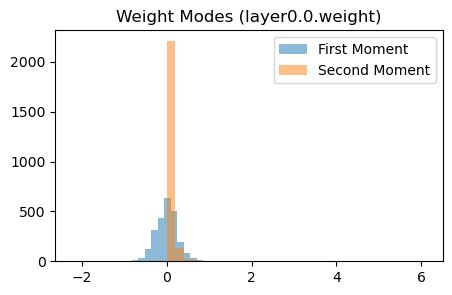

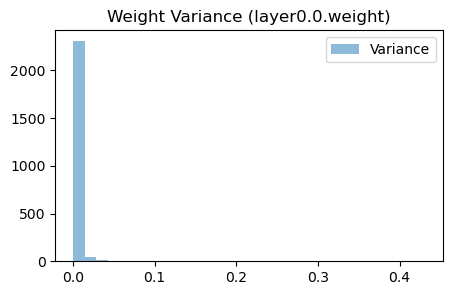

In [27]:
plt.figure(figsize=(5, 3))

plt.hist(swag.weights_first_moment[layer_name].ravel(), bins=30, alpha=0.5, label='First Moment')
plt.hist(swag.weights_second_moment[layer_name].ravel(), bins=30, alpha=0.5, label='Second Moment')

plt.title(f'Weight Modes ({layer_name})')
plt.legend()

plt.figure(figsize=(5, 3))
plt.hist(weights_variance[layer_name], bins=30, alpha=0.5, label='Variance')

plt.title(f'Weight Variance ({layer_name})')
plt.legend()

plt.show()

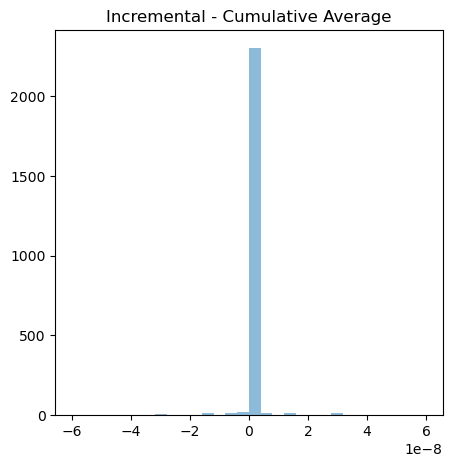

In [16]:
plt.figure(figsize=(5, 5))
plt.hist(weights_avg_errors.detach().numpy().ravel(), bins=30, alpha=0.5, label='Incremental - Cumulative Average')
plt.title("Incremental - Cumulative Average")
plt.show()